Text(0.5, 1.0, 'convex_hull image')

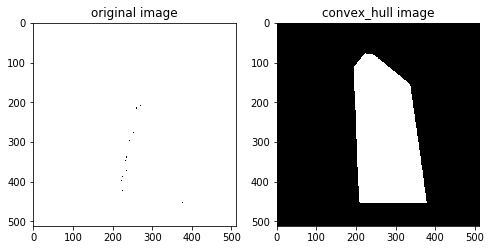

In [7]:
import matplotlib.pyplot as plt
from skimage import data,color,morphology

#生成二值测试图像
img=color.rgb2gray(data.camera())
img=(img<0.7)*1

chull = morphology.convex_hull_image(img)

#绘制轮廓
fig, axes = plt.subplots(1,2,figsize=(8,8))
ax0, ax1= axes.ravel()
ax0.imshow(255-img,plt.cm.gray)
ax0.set_title('original image')

ax1.imshow(chull,plt.cm.gray)
ax1.set_title('convex_hull image')

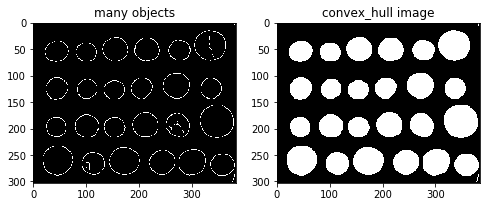

In [8]:
import matplotlib.pyplot as plt
from skimage import data,color,morphology,feature

#生成二值测试图像
img=color.rgb2gray(data.coins())
#检测canny边缘,得到二值图片
edgs=feature.canny(img, sigma=3, low_threshold=10, high_threshold=50) 

chull = morphology.convex_hull_object(edgs)

#绘制轮廓
fig, axes = plt.subplots(1,2,figsize=(8,8))
ax0, ax1= axes.ravel()
ax0.imshow(edgs,plt.cm.gray)
ax0.set_title('many objects')
ax1.imshow(chull,plt.cm.gray)
ax1.set_title('convex_hull image')
plt.show()

regions number: 9


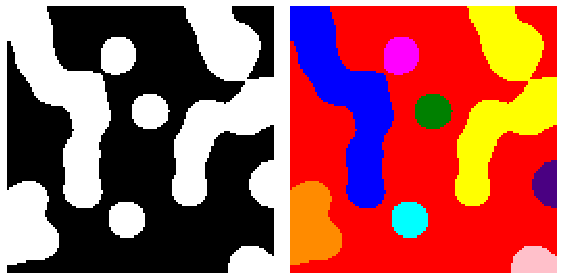

In [9]:
#2、连通区域标记
import numpy as np
import scipy.ndimage as ndi
from skimage import measure,color
import matplotlib.pyplot as plt

#编写一个函数来生成原始二值图像
def microstructure(l=256):
    n = 5
    x, y = np.ogrid[0:l, 0:l]  #生成网络
    mask = np.zeros((l, l))
    generator = np.random.RandomState(1)  #随机数种子
    points = l * generator.rand(2, n**2)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndi.gaussian_filter(mask, sigma=l/(4.*n)) #高斯滤波
    return mask > mask.mean()

data = microstructure(l=128)*1 #生成测试图片

labels=measure.label(data,connectivity=2)  #8连通区域标记
dst=color.label2rgb(labels)  #根据不同的标记显示不同的颜色
print('regions number:',labels.max()+1)  #显示连通区域块数(从0开始标记)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(data, plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dst,interpolation='nearest')
ax2.axis('off')

fig.tight_layout()
plt.show()

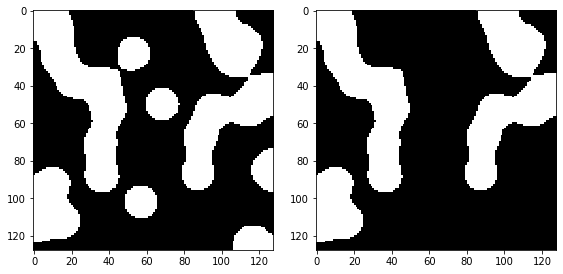

In [10]:
#3、删除小块区域
import numpy as np
import scipy.ndimage as ndi
from skimage import morphology
import matplotlib.pyplot as plt

#编写一个函数来生成原始二值图像
def microstructure(l=256):
    n = 5
    x, y = np.ogrid[0:l, 0:l]  #生成网络
    mask = np.zeros((l, l))
    generator = np.random.RandomState(1)  #随机数种子
    points = l * generator.rand(2, n**2)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndi.gaussian_filter(mask, sigma=l/(4.*n)) #高斯滤波
    return mask > mask.mean()

data = microstructure(l=128) #生成测试图片

dst=morphology.remove_small_objects(data,min_size=300,connectivity=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(data, plt.cm.gray, interpolation='nearest')
ax2.imshow(dst,plt.cm.gray,interpolation='nearest')

fig.tight_layout()
plt.show()


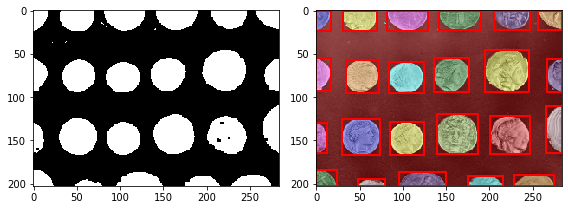

In [14]:
 #4、综合示例：阈值分割+闭运算+连通区域标记+删除小区块+分色显示
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import data,filters,segmentation,measure,morphology,color

#加载并裁剪硬币图片
image = data.coins()[50:-50, 50:-50]

thresh =filters.threshold_otsu(image) #阈值分割
bw =morphology.closing(image > thresh, morphology.square(3)) #闭运算

cleared = bw.copy()  #复制
segmentation.clear_border(cleared)  #清除与边界相连的目标物

label_image =measure.label(cleared)  #连通区域标记
borders = np.logical_xor(bw, cleared) #异或
label_image[borders] = -1
image_label_overlay =color.label2rgb(label_image, image=image) #不同标记用不同颜色显示

fig,(ax0,ax1)= plt.subplots(1,2, figsize=(8, 6))
ax0.imshow(cleared,plt.cm.gray)
ax1.imshow(image_label_overlay)

for region in measure.regionprops(label_image): #循环得到每一个连通区域属性集
    
    #忽略小区域
    if region.area < 100:
        continue

    #绘制外包矩形
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax1.add_patch(rect)
fig.tight_layout()
plt.show() 

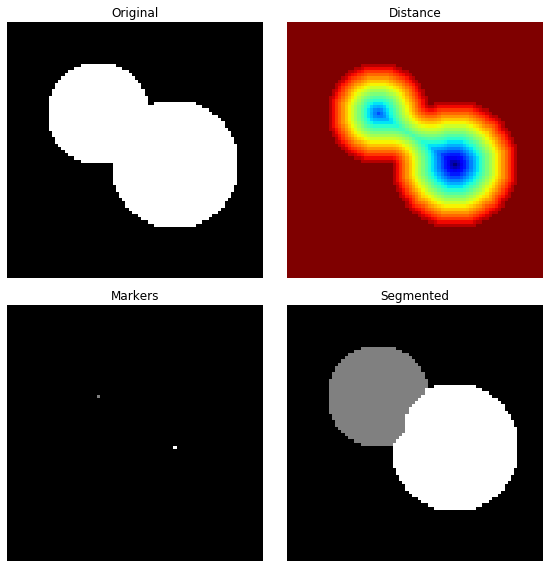

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology,feature

#创建两个带有重叠圆的图像
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

#现在我们用分水岭算法分离两个圆
distance = ndi.distance_transform_edt(image) #距离变换
local_maxi =feature.peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)   #寻找峰值
markers = ndi.label(local_maxi)[0] #初始标记点
labels =morphology.watershed(-distance, markers, mask=image) #基于距离变换的分水岭算法

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes = axes.ravel()
ax0, ax1, ax2, ax3 = axes

ax0.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax0.set_title("Original")
ax1.imshow(-distance, cmap=plt.cm.jet, interpolation='nearest')
ax1.set_title("Distance")
ax2.imshow(markers, cmap=plt.cm.gray, interpolation='nearest')
ax2.set_title("Markers")
ax3.imshow(labels, cmap=plt.cm.gray, interpolation='nearest')
ax3.set_title("Segmented")

for ax in axes:
    ax.axis('off')

fig.tight_layout()
plt.show()